In [139]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [140]:
analysis_date = dt.date(2022, 1, 12)

In [141]:
lbt_itp_id = 170

In [142]:
importlib.reload(utils)
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [5]:
colorscale = branca.colormap.step.RdYlGn_10.scale(vmin=0, 
 vmax=30)
colorscale.caption = "Speed (miles per hour)"

In [6]:
pbar = tqdm()

0it [00:00, ?it/s]

In [7]:
%%capture
lbt = rt.OperatorDayAnalysis(lbt_itp_id, analysis_date, pbar)

In [8]:
lbt.set_filter(start_time='15:00', end_time='19:00', direction_id='1')

In [9]:
%%capture
m = lbt.segment_speed_map(colorscale=colorscale)

In [10]:
# m

In [11]:
lbt.routelines

,calitp_itp_id,calitp_url_number,shape_id,geometry
0,170,0,10069,"LINESTRING (161216.993 -459406.837, 161188.049..."
1,170,0,10070,"LINESTRING (165555.589 -461447.899, 165529.874..."
2,170,0,1010081,"LINESTRING (178338.638 -463053.608, 178362.517..."
3,170,0,1010082,"LINESTRING (165274.717 -466518.693, 165274.621..."
4,170,0,1030063,"LINESTRING (171925.408 -460990.847, 171924.612..."
...,...,...,...,...
115,170,0,940134,"LINESTRING (167488.905 -470302.205, 167525.719..."
116,170,0,940136,"LINESTRING (167488.905 -470302.205, 167525.719..."
117,170,0,940137,"LINESTRING (173618.815 -467099.690, 173618.999..."
118,170,0,940138,"LINESTRING (173635.077 -467088.166, 173634.516..."


In [12]:
lbt.trips_positions_joined >> filter(_.route_id == '51') >> distinct(_.direction_id, _.shape_id, _keep_all=True)

,calitp_itp_id,service_date,trip_key,trip_id,route_id,direction_id,shape_id,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
0,170,2022-01-12,6460889386703071205,9289374,51,0,510067,1224,None,2022-01-12 08:14:18,33.876743,-118.22327,2022-01-12 08:14:55,POINT (164389.396 -458297.602)
1,170,2022-01-12,-9094923369855237176,9288369,51,1,510066,1224,None,2022-01-12 18:49:57,33.768055,-118.19030,2022-01-12 18:50:10,POINT (167669.594 -470291.215)


single shape_id for each route_id x direction_id... (by spec)

goal is to identify linked shape ids and shift by direction (to either side of centerline), plus shape segments to display progression

### Shape Manipulation

In [158]:
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [159]:
one_interpolator = lbt.position_interpolators['9288385']['rt']

In [160]:
rt.VehiclePositionsInterpolator.detailed_speed_map(one_interpolator)

/home/jovyan/data-analyses/rt_delay/rt_analysis.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [161]:
ex = one_interpolator.detailed_map_view.copy()

In [163]:
turn = ex.loc[12514]

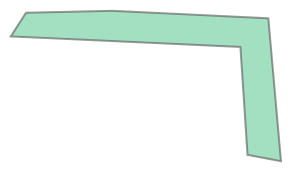

In [164]:
turn.geometry

In [64]:
clip = shapely.geometry.Point(ex.geometry.centroid.x, ex.geometry.bounds[1]).buffer(25)

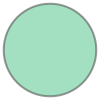

In [65]:
clip

In [86]:
top = (ex.geometry.centroid.x, ex.geometry.bounds[1] + 50)

lower_left = (ex.geometry.bounds[0] - 25, ex.geometry.bounds[1])
lower_right = (ex.geometry.bounds[2] + 25, ex.geometry.bounds[1])

In [87]:
ex.geometry.bounds

(168143.1385600684, -469402.023818873, 168184.10427258976, -468956.3750499524)

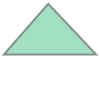

In [88]:
clip2 = shapely.geometry.Polygon((top, lower_left, lower_right))
clip2

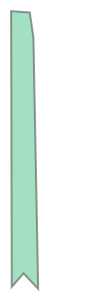

In [89]:
ex.geometry.difference(clip2)

In [118]:
left_side = ex.geometry.bounds[0]
right_side = ex.geometry.bounds[2]
top_side = ex.geometry.bounds[3]

In [125]:
vertex_1 = (left_side, top_side)
vertex_2 = (right_side, top_side)
vertex_3 = (right_side, top_side - 45)
vertex_4 = (ex.geometry.centroid.x, top_side - 10)
vertex_5 = (left_side, top_side - 45)

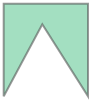

In [126]:
clip3 = shapely.geometry.Polygon((vertex_1, vertex_2, vertex_3,
                                 vertex_4, vertex_5))
clip3

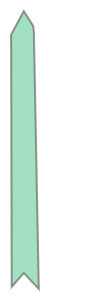

In [127]:
ex.geometry.difference(clip2).difference(clip3)